In [1]:
"""Training script smpl deformation space experiment.
"""
import argparse
import json
import os
import glob
import numpy as np
from collections import defaultdict
import warnings
import time
import trimesh
from utils import render
import torch
import tqdm
from shapeflow.layers.deformation_layer import NeuralFlowDeformer
from shapeflow.layers.chamfer_layer import ChamferDistKDTree

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
# functions
def trace_pts(v_seq, idxs=[0]):
    """create tracer lines by tracing points.
    
    Args:
      v_seq:  [nsteps, #v, 3]
    """
    ns = v_seq.shape[0]
    nt = len(idxs)
    idxs = np.array(idxs)
    v_traced = v_seq[:, idxs, :]
    verts = v_traced.reshape(-1, 3)
    sid = np.arange(ns*nt).reshape([ns, nt])[:-1].reshape(-1)
    eid = np.arange(ns*nt).reshape([ns, nt])[1:].reshape(-1)
    edges = np.stack([sid, eid], axis=1)
    lines = render.line_meshes(verts, edges)
    return lines


def edge_lengths(verts, edges):
    verts_0 = verts[..., edges[:, 0], :]
    verts_1 = verts[..., edges[:, 1], :]
    edgelen = torch.norm(verts_1 - verts_0, dim=-1)
    return edgelen  # [batch, #e]


def spmatmul(den, sp):
    """
    den: Dense tensor of shape batch_size x in_chan x #V
    sp : Sparse tensor of shape newlen x #V
    """
    batch_size, in_chan, nv = list(den.size())
    new_len = sp.size()[0]
    den = den.permute(2, 1, 0).contiguous().view(nv, -1)
    res = torch.spmm(sp, den).view(new_len, in_chan, batch_size).contiguous().permute(2, 1, 0)
    return res


# Load meshes

In [3]:
data_dir = "data/smpl_animation"
device = torch.device("cuda:0")

d = np.load(os.path.join(data_dir, "meshes.npz"))
faces = d['faces']
batch_verts = d['batch_verts']

n_shapes = len(batch_verts)
verts_t = torch.from_numpy(batch_verts).float().to(device) * 5

# edges
m = trimesh.Trimesh(batch_verts[0], faces, process=False)
edges = m.edges
edges_t = torch.from_numpy(edges).to(device)

/home/max.jiang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  


# \[Experiment] Deform between pairs
[!] Run the different scenarios presented in the paper by switching between case names (as in Main Options).

Note that the divergence free versions are relatively slower due to additional compuational overhead.

## Main Options

In [26]:
case = "shapeflow_divfree_edge2"  # choice of one of below
CASES = ["shapeflow_edge0", "shapeflow_divfree_edge0", "shapeflow_divfree_edge2"]
# NOTE: divfree versions might be slow...

## Additional Options

In [27]:
# options
deformer_nf = 16  # number of base feature layers in deformer
atol = 1e-2
rtol = 1e-2
nonlin = 'elu'
adjoint = False
solver = 'rk4'
niter = 1000  # number of iterations
optimizer = torch.optim.Adam
learning_rate = 2e-3
criterion = torch.nn.L1Loss() # torch.nn.MSELoss()
log_per_n_iter = 20
nsteps = 5  # number of integration steps. the higher this value, the more accurate the ODE integration is.

## Setup

In [28]:
# parse options
# combinations of parameters
OPTIONS_0 = {
    "name": CASES[0],
    "divfree": False,
    "alpha_edge": 0,
}

OPTIONS_1 = {
    "name": CASES[1],
    "divfree": True,
    "alpha_edge": 0,
}

OPTIONS_2 = {
    "name": CASES[2],
    "divfree": True,
    "alpha_edge": 2,
}

OPTIONS = {CASES[0]: OPTIONS_0, CASES[1]: OPTIONS_1, CASES[2]: OPTIONS_2}
option = OPTIONS[case]

divfree = option["divfree"]  # use divergence free parameterization
alpha_edge = option["alpha_edge"]

# setup model
deformer = NeuralFlowDeformer(latent_size=1, f_width=deformer_nf, s_nlayers=2, 
                              s_width=5, method=solver, nonlinearity=nonlin, arch='imnet',
                              adjoint=adjoint, rtol=rtol, atol=atol, via_hub=False,
                              no_sign_net=False, return_waypoints=True, use_latent_waypoints=True,
                              divfree=divfree)

# for the linear case, we do not require the lat_params to be trainable.
lat_params = torch.linspace(-1, 1, nsteps)[:, None]  # lat_params = torch.linspace(-1, 1, n_shapes)[:, None]
lat_params = lat_params.unsqueeze(0).to(device)
deformer.to(device)
optim = optimizer(deformer.parameters(), lr=learning_rate)
rev_seq = np.arange(lat_params.shape[1]-1, -1, -1)

## Training (Fitting)

In [29]:
# training loop:
v_src = verts_t[0:1]  # [1, nverts, 3]
v_tar = verts_t[-10:-9] + torch.tensor([-.5, 0., 0.]).to(device)  # [1, nverts, 3]
v_src_tar = torch.cat([v_src, v_tar], dim=0)
v_tar_src = torch.cat([v_tar, v_src], dim=0)
l_src_tar = torch.cat([lat_params, lat_params[:, rev_seq]], dim=0)
e_src = edge_lengths(v_src, edges_t)
a = torch.linspace(0, 1, nsteps).to(device)[:, None, None]
v_lin = (1-a) * v_src + a * v_tar

print(f"Optimizing for {niter} iterations...")
for it in range(niter):
    optim.zero_grad()
    v_prd_seq = deformer(v_src_tar, l_src_tar)  # [nsteps, 2, nverts, 3]
    v_prd_mean = 0.5*(v_prd_seq[:, 0] + v_prd_seq[rev_seq, 1])
    v_p = v_prd_seq.reshape(-1, v_prd_seq.shape[-2], 3)
    e_prd = edge_lengths(v_p, edges_t)
    loss_fit = criterion(v_prd_mean, v_lin)
    loss_edge = criterion(e_prd-e_src, torch.zeros_like(e_prd))
    loss = loss_fit + loss_edge * alpha_edge
    loss.backward()
    optim.step()
    
    if it % log_per_n_iter == 0:
        print(f"Iter {it:4d}: loss {loss.item():.3e}, loss_fit {loss_fit.item():.3e}, "
              f"loss_edge {loss_edge.item():.3e}")

Optimizing for 1000 iterations...
Iter    0: loss 7.489e-02, loss_fit 7.467e-02, loss_edge 1.111e-04
Iter   20: loss 2.256e-02, loss_fit 2.153e-02, loss_edge 5.170e-04
Iter   40: loss 1.191e-02, loss_fit 1.084e-02, loss_edge 5.343e-04
Iter   60: loss 1.028e-02, loss_fit 9.420e-03, loss_edge 4.276e-04
Iter   80: loss 9.786e-03, loss_fit 8.883e-03, loss_edge 4.516e-04
Iter  100: loss 9.409e-03, loss_fit 8.517e-03, loss_edge 4.463e-04
Iter  120: loss 9.256e-03, loss_fit 8.377e-03, loss_edge 4.395e-04
Iter  140: loss 9.163e-03, loss_fit 8.282e-03, loss_edge 4.405e-04
Iter  160: loss 8.993e-03, loss_fit 8.108e-03, loss_edge 4.425e-04
Iter  180: loss 8.745e-03, loss_fit 7.854e-03, loss_edge 4.454e-04
Iter  200: loss 8.494e-03, loss_fit 7.591e-03, loss_edge 4.515e-04
Iter  220: loss 7.991e-03, loss_fit 7.060e-03, loss_edge 4.655e-04
Iter  240: loss 5.516e-03, loss_fit 4.564e-03, loss_edge 4.757e-04
Iter  260: loss 5.662e-03, loss_fit 4.795e-03, loss_edge 4.337e-04
Iter  280: loss 4.830e-03, l

## Visualize deformation results

Animation sequence visualization; Case: shapeflow_divfree_edge2


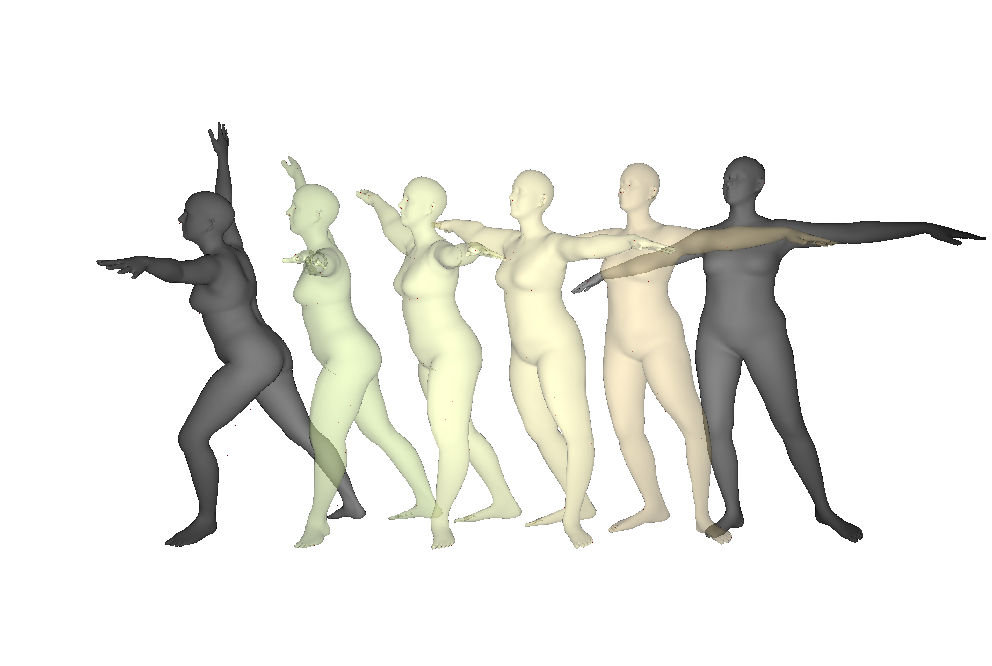

<Figure size 432x288 with 0 Axes>

Volume change through deformation; Case: shapeflow_divfree_edge2


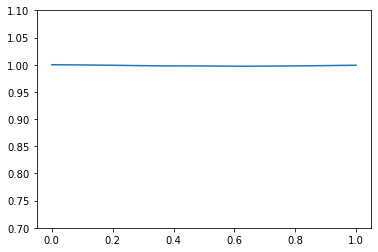

In [30]:
# evaluate
neval = 21
subsamp = 4

lat_params_ = torch.linspace(-1, 1, neval)[None, :, None].to(device)
rev_seq_ = np.arange(lat_params_.shape[1]-1, -1, -1)
v_src_tar_ = torch.cat([v_src, v_tar], dim=0)
l_src_tar_ = torch.cat([lat_params_, lat_params_[:, rev_seq_]], dim=0)
with torch.no_grad():
    v_prd_seq_ = deformer(v_src_tar_, l_src_tar_)  # [nsteps, nverts, 3]

v_prd = v_prd_seq_.detach().cpu().numpy()
v_prd_mean = 0.5*(v_prd[:, 0] + v_prd[rev_seq_, 1])

meshes = [trimesh.Trimesh(v_prd_mean[i], faces) for i in range(v_prd.shape[0])]
mesh0 = trimesh.Trimesh(v_prd[0, 0], faces)
mesh1 = trimesh.Trimesh(v_prd[0, 1], faces)
color0 = np.array([1., .7, .4, .6])
color1 = np.array([.7, 1., .4, .6])
for i, m in enumerate(meshes):
    a = i * 1 / (len(meshes) - 1)
    c = a * color1 + (1-a) * color0
    m.visual.vertex_colors = c
picks = np.genfromtxt("verts_trace.txt").astype(int)
# lines = trace_pts(v_prd_mean, idxs=picks)#[2545, 6000, 4165+1]
pts = v_prd_mean[::subsamp, picks, :].reshape([-1, 3])
pts = trimesh.PointCloud(pts, colors=np.array([1., 0., 0.]))

# Rendering view point
eye = [.2, 0., +1.]
zoom = 0.6
d_eye = np.linalg.norm(eye)
center = 0.5*np.sum(0.5*(mesh0.bounding_box.bounds + mesh1.bounding_box.bounds), 0)
eye = np.array(eye) / d_eye * zoom + center
up = [0, 1, 0]

# img_all, _, _, _ = render.render_trimesh(meshes[::subsamp][1:-1] + [mesh0, mesh1, lines, pts], eye, center, up, res=(2048*1.5, 2048), light_intensity=2, point_size=3)
img_all, _, _, _ = render.render_trimesh(meshes[::subsamp][1:-1] + [mesh0, mesh1, pts], eye, center, up, res=(2048*1.5, 2048), light_intensity=2, point_size=3)


name = option["name"]
subdir = "anim_debug"

os.makedirs(f'paper_figures/{subdir}/{name}', exist_ok=True)
for i, m in enumerate(meshes):
    _ = m.export(os.path.join(f'paper_figures/{subdir}/{name}', f'mesh_{i}.ply'))

print(f"Animation sequence visualization; Case: {name}")
plt.figure(figsize=(24, 12))
plt.imshow(img_all)
plt.axis('off')
plt.show()
plt.savefig(f'paper_figures/{subdir}/{name}.png')
plt.show()

# save volume curve
print(f"Volume change through deformation; Case: {name}")
plt.figure()
alpha = np.linspace(0, 1, len(meshes))
rel_vol = np.array([m.volume/meshes[0].volume for m in meshes])
np.savez(f'paper_figures/{subdir}/{name}.npz', alpha=alpha, rel_vol=rel_vol)
plt.plot(alpha, rel_vol)
plt.ylim(.7, 1.1)
plt.show()

# Linear Interpolation

Volume change through deformation; Case: linear


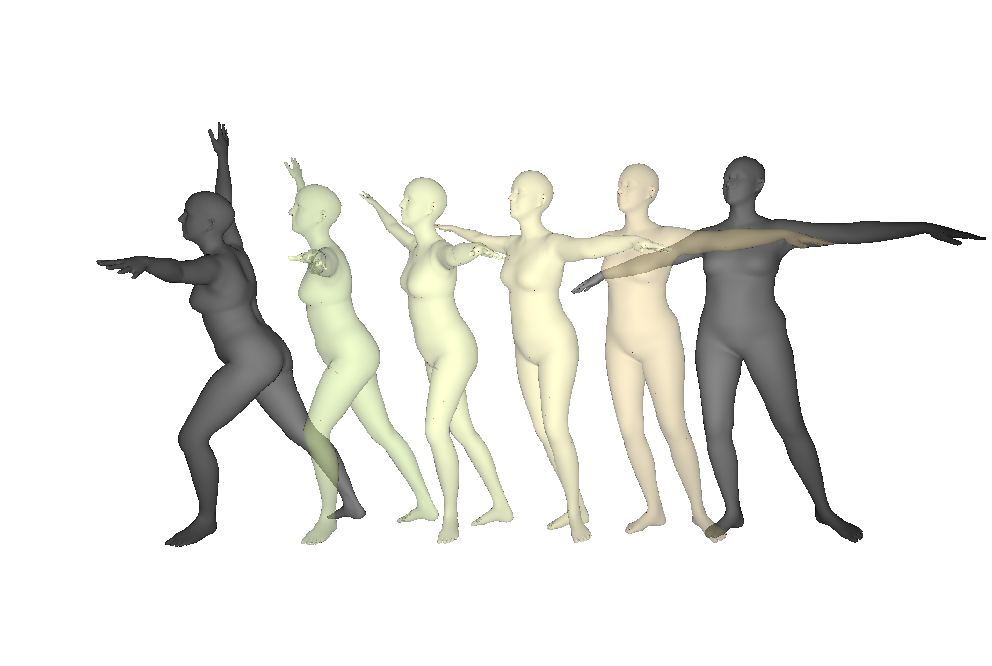

Volume change through deformation; Case: linear


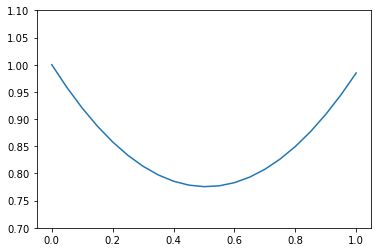

In [31]:
v0 = v_src[0].detach().cpu().numpy()
v1 = v_tar[0].detach().cpu().numpy()
alpha_ = alpha[:, None, None]
v_prd_mean = (1-alpha_) * v0 + alpha_ * v1

meshes = [trimesh.Trimesh(v_prd_mean[i], faces) for i in range(v_prd.shape[0])]
mesh0 = trimesh.Trimesh(v_prd[0, 0], faces)
mesh1 = trimesh.Trimesh(v_prd[0, 1], faces)
color0 = np.array([1., .7, .4, .6])
color1 = np.array([.7, 1., .4, .6])
for i, m in enumerate(meshes):
    a = i * 1 / (len(meshes) - 1)
    c = a * color1 + (1-a) * color0
    m.visual.vertex_colors = c
picks = np.genfromtxt("verts_trace.txt").astype(int)
# lines = trace_pts(v_prd_mean, idxs=picks)#[2545, 6000, 4165+1]
pts = v_prd_mean[::subsamp, picks, :].reshape([-1, 3])
pts = trimesh.PointCloud(pts, colors=np.array([1., 0., 0.]))


# img_all, _, _, _ = render.render_trimesh(meshes[::subsamp] + [mesh0, mesh1, lines, pts], eye, center, up, res=(2048*1.5, 2048), light_intensity=2, point_size=3)
img_all, _, _, _ = render.render_trimesh(meshes[::subsamp] + [mesh0, mesh1, pts], eye, center, up, res=(2048*1.5, 2048), light_intensity=2, point_size=3)

name = "linear"

os.makedirs(f'paper_figures/{subdir}/{name}', exist_ok=True)
for i, m in enumerate(meshes):
    _ = m.export(os.path.join(f'paper_figures/{subdir}/{name}', f'mesh_{i}.ply'))

# save volume curve
print(f"Volume change through deformation; Case: {name}")
plt.figure(figsize=(24, 12))
plt.imshow(img_all)
plt.axis('off')
# plt.show()
plt.savefig(f'paper_figures/{subdir}/{name}.png')
plt.show()

# save volume curve
print(f"Volume change through deformation; Case: {name}")
alpha = np.linspace(0, 1, len(meshes))
rel_vol = np.array([m.volume/meshes[0].volume for m in meshes])
np.savez(f'paper_figures/{subdir}/{name}.npz', alpha=alpha, rel_vol=rel_vol)
plt.plot(alpha, rel_vol)
plt.ylim(.7, 1.1)
plt.show()

# Plot combined volume change figure (AFTER running all cases, as well as the linear case)

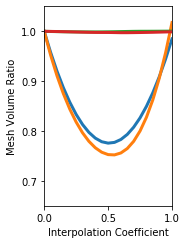

In [32]:
# plot combined volume curve
names = ["linear", "shapeflow_edge0", "shapeflow_divfree_edge0", "shapeflow_divfree_edge2"]
labels = ["Linear Interpolation", "Shapeflow", "Shapeflow+Divfree", "Shapeflow+Divfree+Edge"]
plt.figure(figsize=(2.7, 3.5))
for name, label in zip(names, labels):
    d = np.load(os.path.join(f"paper_figures/{subdir}/{name}.npz"))
    plt.plot(d['alpha'], d['rel_vol'], label=label, linewidth=3)
# plt.legend(loc='lower center')
plt.xlim(0.0, 1.0)
plt.ylim(.65, 1.05)
plt.xticks([0, 0.5, 1])
plt.yticks(np.linspace(0.7, 1, 4))
plt.xlabel("Interpolation Coefficient")
plt.ylabel("Mesh Volume Ratio")
plt.tight_layout()
# plt.show()
plt.savefig(f"paper_figures/{subdir}/volume_change.pdf")